# **1. Install packages**

In [36]:
%%capture
!pip install torchinfo

# **2. Import libraries**

In [13]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Preprocessing
from sklearn.model_selection import train_test_split
from collections import Counter

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# random
import random

# typing
from typing import Dict,List

# warnings
import warnings
warnings.filterwarnings("ignore")

# **3. Load data and EDA**

In [14]:
# Total Images
IMAGE_PATH = Path("TrashType_Image_Dataset")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))

print(f"Total Images = {len(IMAGE_PATH_LIST)}")

Total Images = 2527


In [15]:
# Total Images per class
classes = [folder.name for folder in IMAGE_PATH.iterdir() if folder.is_dir()]
classes = sorted(classes)

print("**" * 30)
print(" " * 17, "Total Images per class")
print("**" * 30)
for c in classes:
    imgs_class = len(list(Path(os.path.join(IMAGE_PATH / c)).glob("*.jpg")))
    print(f"* {c} => {imgs_class} images")

************************************************************
                  Total Images per class
************************************************************
* cardboard => 403 images
* glass => 501 images
* metal => 410 images
* paper => 594 images
* plastic => 482 images
* trash => 137 images


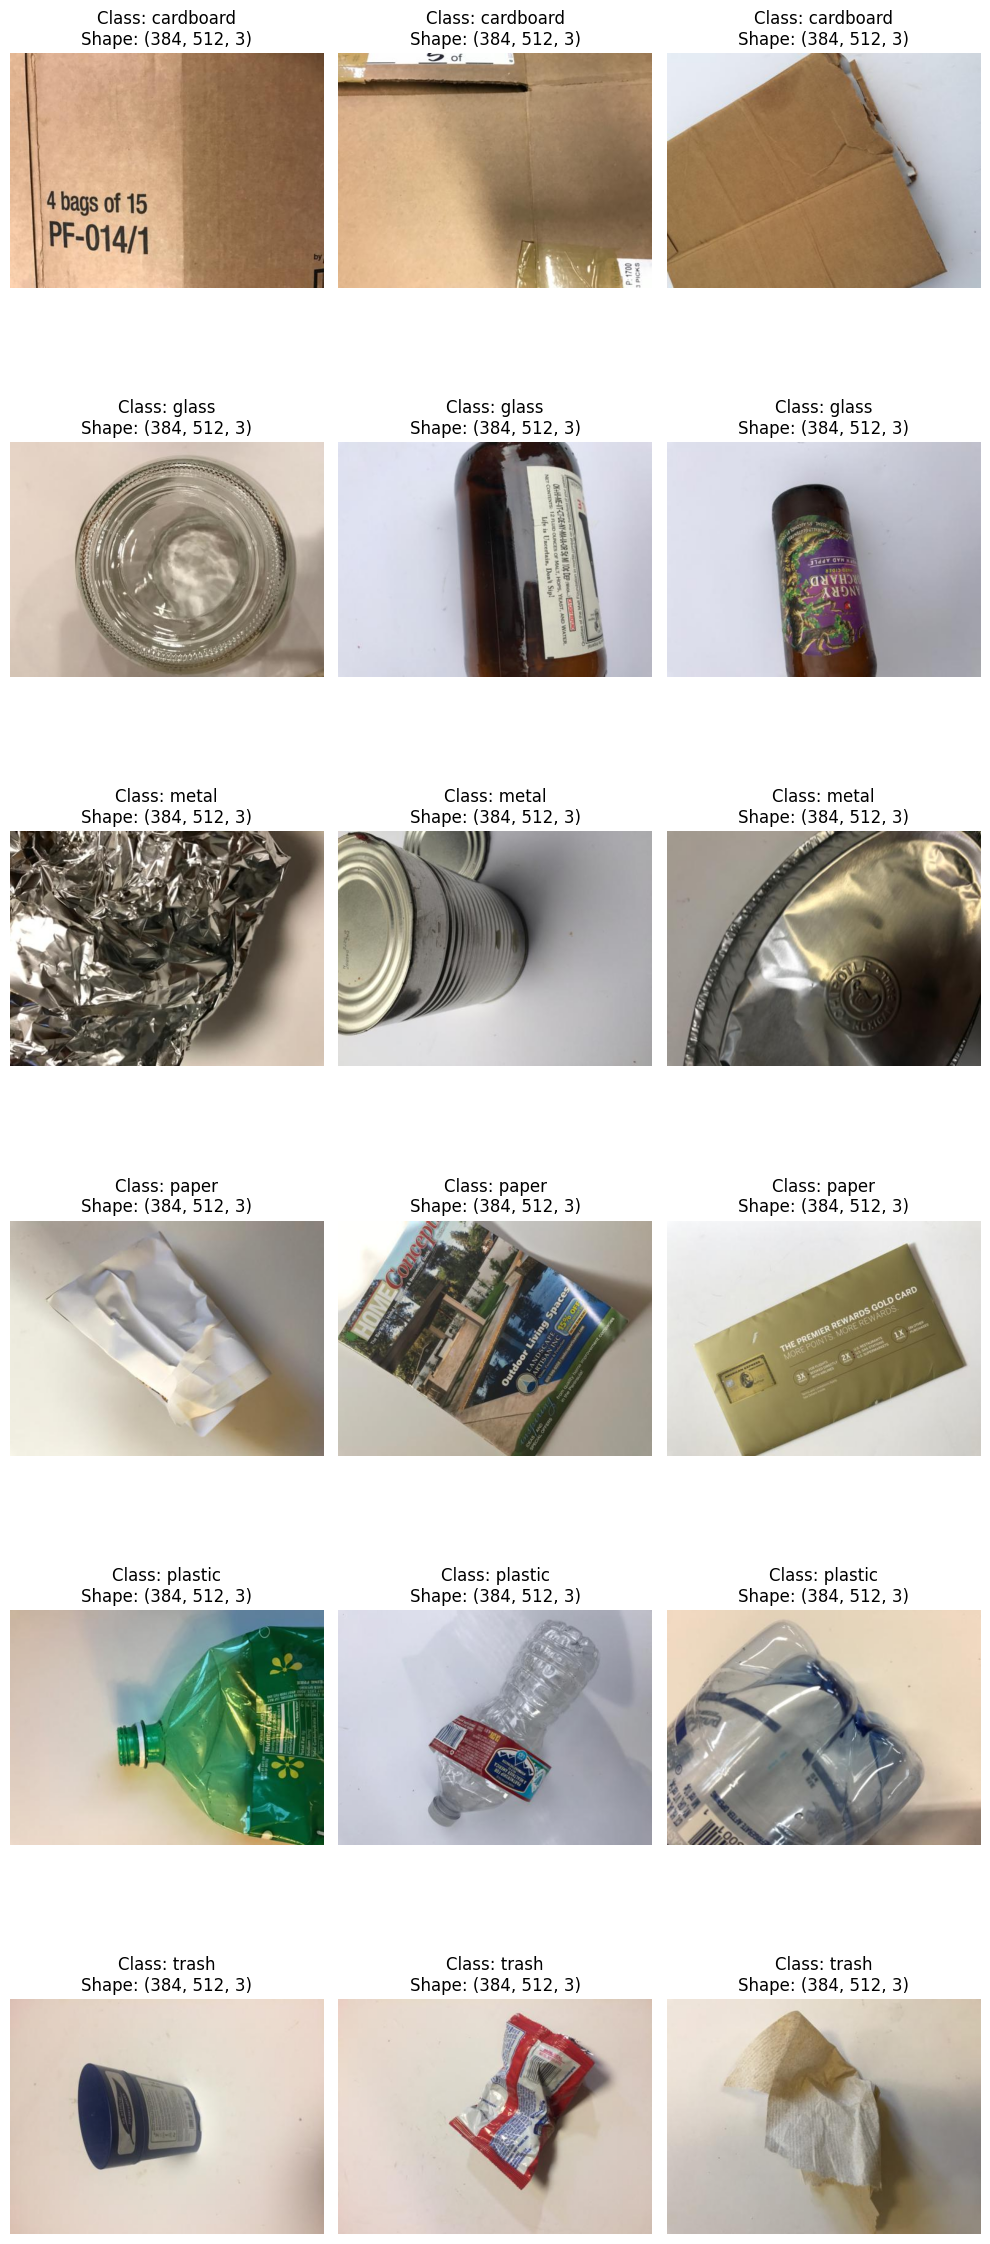

In [16]:
# We view some images per class.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), 
                       ncols = NUM_IMAGES, 
                       figsize = (10, 24))

p = 0
for row, c in enumerate(classes):
    imgs_total = list((IMAGE_PATH / c).glob("*.jpg"))
    imgs_selected = random.choices(imgs_total, k = NUM_IMAGES)
    
    for i,img_select in enumerate(imgs_selected):
        img_bgr = cv2.imread(str(img_select))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p,i].axis("off")
        
    p += 1
    
fig.tight_layout()
fig.show()

# **4. Preprocessing**

We create a dataframe where we store the paths and labels of the images.

In [41]:
path = [None] * len(IMAGE_PATH_LIST)
label = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    path[i] = img_path
    label[i] = img_path.parent.stem
    
df_path_label = pd.DataFrame({"path":path, 
                              "label":label})

df_path_label.head()

,path,label
0,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard
1,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard
2,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard
3,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard
4,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard


Split the dataframe into 3 sets of images:

- **`Train = 70%`**
- **`Valid = 15%`**
- **`Test = 15%`**

In [42]:
# We define the random seed for reproducibility.
SEED = 123

df_train, df_rest = train_test_split(df_path_label, 
                                     test_size = 0.3, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_path_label["label"])

df_valid, df_test = train_test_split(df_rest, 
                                     test_size = 0.5, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_rest["label"])

In [43]:
Counter(df_train["label"])

Counter({'paper': 416,
         'glass': 350,
         'plastic': 337,
         'metal': 287,
         'cardboard': 282,
         'trash': 96})

In [44]:
Counter(df_valid["label"])

Counter({'paper': 89,
         'glass': 75,
         'plastic': 72,
         'metal': 61,
         'cardboard': 61,
         'trash': 21})

In [45]:
Counter(df_test["label"])

Counter({'paper': 89,
         'glass': 76,
         'plastic': 73,
         'metal': 62,
         'cardboard': 60,
         'trash': 20})

Now we have to define the mapping to convert the labels to numbers.

In [46]:
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

We apply the mapping.

In [47]:
df_train["label"] = df_train["label"].map(label_map)
df_valid["label"] = df_valid["label"].map(label_map)

Well, it is always good to reset the index, so as not to have any problems.

In [48]:
df_train = df_train.reset_index(drop = True)
df_valid = df_valid.reset_index(drop = True)

Now we define the transformations that we are going to perform on the images.

In [5]:
weights = EfficientNet_B7_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[600]
    resize_size=[600]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

This is the last step, creating the **`Dataset's`** and **`DataLoader's`**.

- **Dataset's**

In [50]:
class CustomDataset:
    def __init__(self, df:pd.DataFrame, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = self.df.iloc[idx, 1]
        
        return image,label

In [51]:
train_dataset = CustomDataset(df_train, auto_transforms)
valid_dataset = CustomDataset(df_valid, auto_transforms)

- **DataLoader's**

In [52]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS,
                              pin_memory=False)

valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS,
                              pin_memory=False)

In [53]:
for i in range(10):  # Check the first 10 samples
    try:
        img, label = train_dataset[i]
        print(f"Sample {i} loaded successfully! Label: {label}")
    except Exception as e:
        print(f"Error loading sample {i}: {e}")



Sample 0 loaded successfully! Label: 1
Sample 1 loaded successfully! Label: 3
Sample 2 loaded successfully! Label: 5
Sample 3 loaded successfully! Label: 1
Sample 4 loaded successfully! Label: 1
Sample 5 loaded successfully! Label: 0
Sample 6 loaded successfully! Label: 4
Sample 7 loaded successfully! Label: 4
Sample 8 loaded successfully! Label: 0
Sample 9 loaded successfully! Label: 3


In [54]:
for i in range(5):
    try:
        batch_images, batch_labels = next(iter(train_dataloader))
        print(f"Batch {i} loaded successfully!")
    except Exception as e:
        print(f"Error in batch {i}: {e}")


Batch 0 loaded successfully!
Batch 1 loaded successfully!
Batch 2 loaded successfully!
Batch 3 loaded successfully!
Batch 4 loaded successfully!


In [55]:
# Let's visualize a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([32, 3, 600, 600]), torch.Size([32]))

Great!!, it turned out well.

# **5. Model**

In [19]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# We define our model.
model = efficientnet_b7(weights = weights)

In [58]:
# Let's take a look at the model.
summary(model = model, 
        input_size = [6,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 16, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape      Output Shape     Param #          Trainable
EfficientNet (EfficientNet)                                  [6, 3, 224, 224] [6, 1000]        --               True
├─Sequential (features)                                      [6, 3, 224, 224] [6, 2560, 7, 7]  --               True
│    └─Conv2dNormActivation (0)                              [6, 3, 224, 224] [6, 64, 112, 112] --               True
│    │    └─Conv2d (0)                                       [6, 3, 224, 224] [6, 64, 112, 112] 1,728            True
│    │    └─BatchNorm2d (1)                                  [6, 64, 112, 112] [6, 64, 112, 112] 128              True
│    │    └─SiLU (2)                                         [6, 64, 112, 112] [6, 64, 112, 112] --               --
│    └─Sequential (1)                                        [6, 64, 112, 112] [6, 32, 112, 112] --               True
│    │    └─MBConv (0)                               

In [59]:
# We freeze the parameters of the extractor layers.
for param in model.features.parameters():
    param.requires_grad = False

In [60]:
# Let's see if the parameters were frozen.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 16, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape      Output Shape     Param #          Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]       --               Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 2560, 7, 7] --               False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 64, 112, 112] --               False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 64, 112, 112] (1,728)          False
│    │    └─BatchNorm2d (1)                                  [32, 64, 112, 112] [32, 64, 112, 112] (128)            False
│    │    └─SiLU (2)                                         [32, 64, 112, 112] [32, 64, 112, 112] --               --
│    └─Sequential (1)                                        [32, 64, 112, 112] [32, 32, 112, 112] --               False
│    │    └─MBConv (0)           

Perfect!!, it turned out well.

Now we have to modify the classifier layer since the output must be equal to the number of classes.

In [61]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [17]:
output_shape = len(classes) # total classes

model.classifier = nn.Sequential(nn.Dropout(p = 0.5, inplace = True), 
                                 nn.Linear(in_features = 2560, 
                                           out_features = output_shape, 
                                           bias = True))

In [63]:
# Finally, let's see if the last layer was modified.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 16, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape      Output Shape     Param #          Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 6]          --               Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 2560, 7, 7] --               False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 64, 112, 112] --               False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 64, 112, 112] (1,728)          False
│    │    └─BatchNorm2d (1)                                  [32, 64, 112, 112] [32, 64, 112, 112] (128)            False
│    │    └─SiLU (2)                                         [32, 64, 112, 112] [32, 64, 112, 112] --               --
│    └─Sequential (1)                                        [32, 64, 112, 112] [32, 32, 112, 112] --               False
│    │    └─MBConv (0)           

Wow!!, it was cool.

Now we have to define the **`loss function`** and the **`optimizer`**.

In [64]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

We will create 4 functions for training our model:

- **`train_step`**
- **`valid_step`**
- **`save_checkpoint`**
- **`train`**

In [65]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = model(X)
        
        # Loss
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        # Gradients = backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # zero gradients
        optimizer.zero_grad()
        
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(), 
                                         y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)
    
    return train_loss, train_accuracy

In [66]:
# Function that stores the best model with the least loss in the validation set.
def save_checkpoint(filename, model, epoch, loss, optimizer, metric):
    state = {"filename":filename, 
             "model":model.state_dict(), 
             "epoch":epoch, 
             "loss":loss, 
             "optimizer":optimizer.state_dict(), 
             "metric":metric}
    
    torch.save(state, filename)

In [67]:
def valid_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module):
    
    model.eval()
    
    valid_loss = 0.
    valid_accuracy = 0.
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            # Loss
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()
            
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)
            valid_accuracy += accuracy_score(y.cpu().numpy(), 
                                             y_pred_class.detach().cpu().numpy())
            
    valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)
    
    return valid_loss, valid_accuracy

In [68]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int):
    
    results = {"train_loss":[], 
               "train_accuracy":[], 
               "valid_loss":[], 
               "valid_accuracy":[]}
    
    best_valid_loss = float("inf")
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        valid_loss, valid_accuracy = valid_step(model = model, 
                                                dataloader = valid_dataloader, 
                                                loss_fn = loss_fn)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, 
                            model, 
                            epoch, 
                            best_valid_loss, 
                            optimizer, 
                            valid_accuracy)
            
        
        print(f"Epoch: {epoch + 1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"Valid Loss: {valid_loss:.4f} | ", 
              f"Valid Accuracy: {valid_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)
        
    return results

In [69]:
# We execute the training!!
EPOCHS = 15
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      valid_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.8601 |  Train Accuracy: 0.7065 |  Valid Loss: 0.5091 |  Valid Accuracy: 0.8236
Epoch: 2 |  Train Loss: 0.5433 |  Train Accuracy: 0.8097 |  Valid Loss: 0.4836 |  Valid Accuracy: 0.8298
Epoch: 3 |  Train Loss: 0.4619 |  Train Accuracy: 0.8348 |  Valid Loss: 0.4428 |  Valid Accuracy: 0.8456
Epoch: 4 |  Train Loss: 0.4467 |  Train Accuracy: 0.8438 |  Valid Loss: 0.4064 |  Valid Accuracy: 0.8548
Epoch: 5 |  Train Loss: 0.4491 |  Train Accuracy: 0.8454 |  Valid Loss: 0.4123 |  Valid Accuracy: 0.8565
Epoch: 6 |  Train Loss: 0.4721 |  Train Accuracy: 0.8404 |  Valid Loss: 0.4114 |  Valid Accuracy: 0.8709
Epoch: 7 |  Train Loss: 0.3697 |  Train Accuracy: 0.8756 |  Valid Loss: 0.3925 |  Valid Accuracy: 0.8788
Epoch: 8 |  Train Loss: 0.3777 |  Train Accuracy: 0.8677 |  Valid Loss: 0.4034 |  Valid Accuracy: 0.8636
Epoch: 9 |  Train Loss: 0.4132 |  Train Accuracy: 0.8566 |  Valid Loss: 0.3987 |  Valid Accuracy: 0.8631
Epoch: 10 |  Train Loss: 0.3661 |  Train Accuracy: 0.87

In [70]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

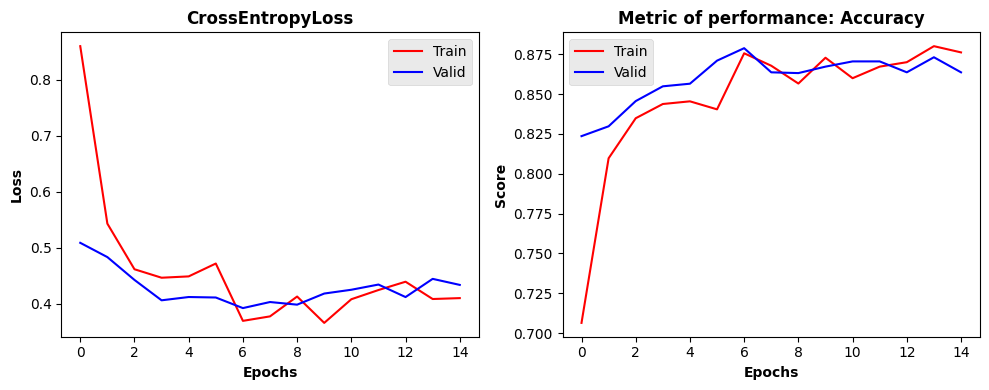

In [71]:
plot_loss_metric_curve(MODEL_RESULTS)

In [9]:
# We load the best model.
checkpoint_path = "best_model.pth"
checkpoint = torch.load(checkpoint_path)

In [10]:
# We visualize the smallest loss in the validation set.
print(f"Epoch: {checkpoint['epoch']}")
print(f"Loss: {checkpoint['loss']}")
print(f"Metric: {checkpoint['metric']}")

Epoch: 6
Loss: 0.39254062871138257
Metric: 0.8787615740740741


# **6. Metrics**

In [11]:
# We apply all the transformations to our test set.
df_test["label"] = df_test["label"].map(label_map)
df_test = df_test.reset_index(drop = True)
test_dataset = CustomDataset(df_test, auto_transforms)
test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS)

NameError: name 'df_test' is not defined

In [20]:
# We use the best model to make predictions on our test set.
loaded_model = efficientnet_b7()
loaded_model.classifier = nn.Sequential(nn.Dropout(p = 0.5, inplace = True), 
                                        nn.Linear(in_features = 2560, 
                                                  out_features = output_shape, 
                                                  bias = True))

loaded_model.load_state_dict(checkpoint["model"])

loaded_model.to(device)

y_pred_test = []

loaded_model.eval()

with torch.inference_mode():
    for X,y in test_dataloader:
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.cpu())

NameError: name 'test_dataloader' is not defined

- **Confusion Matrix**

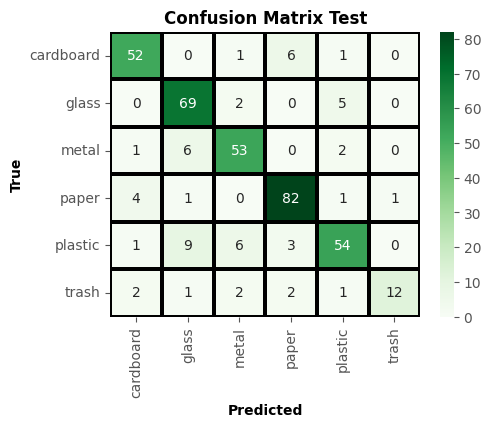

In [76]:
# We visualize the confusion matrix
cf_mx_test = confusion_matrix(df_test["label"],torch.cat(y_pred_test).numpy())

fig,ax = plt.subplots(figsize=(5,3.7))
sns.heatmap(cf_mx_test, 
            cmap = "Greens", 
            annot = True, 
            linewidths = 1.5,
            linecolor = "black",
            xticklabels = classes, 
            yticklabels = classes,
            ax = ax)

ax.set_title("Confusion Matrix Test", fontsize = 12, fontweight = "bold", color = "black")
ax.set_xlabel("Predicted", fontsize = 10, fontweight = "bold", color = "black")
ax.set_ylabel("True", fontsize = 10, fontweight = "bold", color = "black")
fig.show()

- **Accuracy**

In [77]:
print(f"Accuracy: {accuracy_score(df_test['label'],torch.cat(y_pred_test).numpy())}")

Accuracy: 0.8473684210526315


In [ ]:
import torch

# Load the checkpoint
checkpoint = torch.load("best_model.pth")
output_shape = 6
loaded_model = efficientnet_b7()
loaded_model.classifier = nn.Sequential(nn.Dropout(p = 0.5, inplace = True), 
                                        nn.Linear(in_features = 2560, 
                                                  out_features = output_shape, 
                                                  bias = True))

loaded_model.load_state_dict(checkpoint["model"])

device = "cuda" if torch.cuda.is_available() else "cpu"
device

loaded_model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Restore the optimizer's state if you want to resume training
optimizer.load_state_dict(checkpoint["optimizer"])

# Access other metadata (if needed)
epoch = checkpoint["epoch"]
loss = checkpoint["loss"]
metric = checkpoint["metric"]

print(f"Model restored. Last epoch: {epoch}, Loss: {loss}, Metric: {metric}")

NameError: name 'optimizer' is not defined